# AWBS - Project 2

author: Mateusz Domalewski

group: 2

index: 288761

In [1]:
### importing libraries
import polars as pl
import numpy as np
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
import graphviz
pl.Config.set_tbl_rows(100)
plt.style.use('bmh')

In [2]:
### importing data sources
E_COMMERCE = './data/E-commerce_Customer_Behavior_Sheet1.csv'

## satisfaction level of customers of e-commerce shop

In [3]:
ecommerce = pl.read_csv(E_COMMERCE)
## treat ids as strings
ecommerce.cast({"Customer ID" : pl.String})

ecommerce.describe()

statistic,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
str,f64,str,f64,str,str,f64,f64,f64,f64,f64,str
"""count""",350.0,"""350""",350.0,"""350""","""350""",350.0,350.0,350.0,350.0,350.0,"""348"""
"""null_count""",0.0,"""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""2"""
"""mean""",275.5,null,33.597143,null,null,845.381714,12.6,4.019143,0.5,26.588571,null
"""std""",101.180532,null,4.870882,null,null,362.058695,4.155984,0.580539,null,13.440813,null
"""min""",101.0,"""Female""",26.0,"""Chicago""","""Bronze""",410.8,7.0,3.0,0.0,9.0,"""Neutral"""
"""25%""",188.0,null,30.0,null,null,500.75,9.0,3.5,null,15.0,null
"""50%""",276.0,null,33.0,null,null,780.2,12.0,4.1,null,23.0,null
"""75%""",363.0,null,37.0,null,null,1160.6,15.0,4.5,null,38.0,null
"""max""",450.0,"""Male""",43.0,"""San Francisco""","""Silver""",1520.1,21.0,4.9,1.0,63.0,"""Unsatisfied"""


In [4]:
## drop nulls for classes
ecommerce = ecommerce.drop_nulls()

In [5]:
feature_map = {
    "Customer ID" : "customer_id",
    "Gender" : "gender",
    "Age" : "age",
    "City" : "city",
    "Membership Type" : "membership",
    "Total Spend" : "total_spend",
    "Items Purchased" : "items_no",
    "Average Rating" : "rating_avg",
    "Discount Applied" : "discounted",
    "Satisfaction Level" : "satisfaction"
}
ecomm = ecommerce.rename(feature_map).cast({pl.String : pl.Categorical(ordering='lexical')})

In [6]:
ecomm_features = ecomm.select(pl.exclude("satisfaction"))
ecomm_targets = ecomm.select(pl.col("satisfaction")).to_series()

### Target Analysis

['Neutral' 'Satisfied' 'Unsatisfied']


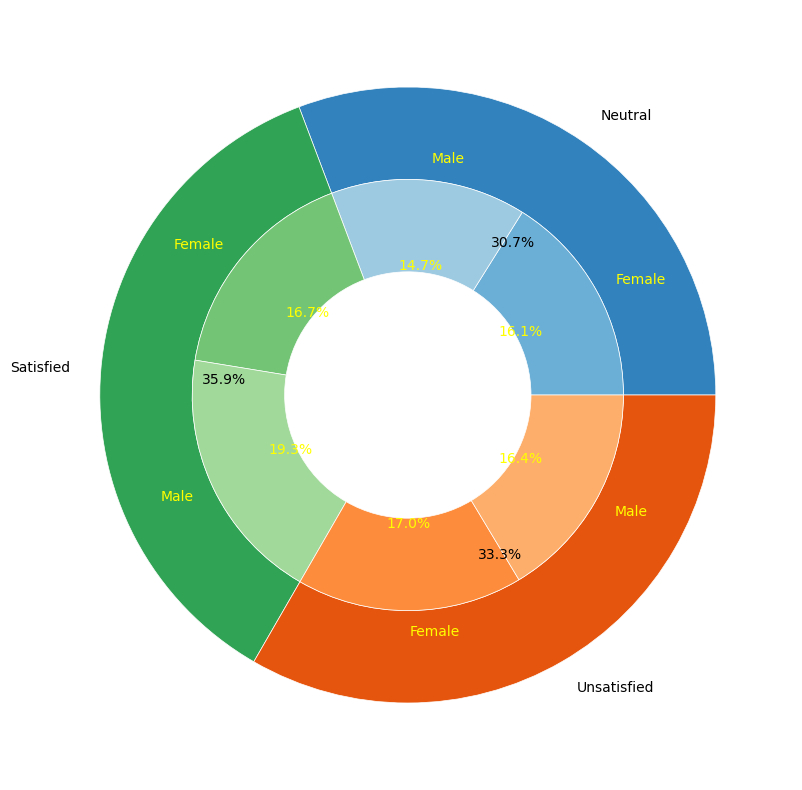

In [7]:
fig, ax = plt.subplots(figsize=[20,10], subplot_kw=dict(aspect="equal"))
size = 0.3
colors = plt.color_sequences['tab20c']

outer_colors = [colors[x] for x in [0, 8, 4]]

inner_colors = [colors[x] for x in [1,2, 9, 10, 5,6]]

target_counts = ecomm_targets.value_counts().sort("satisfaction")

gender_data = ecomm.group_by(pl.col("satisfaction"), pl.col("gender")).agg(pl.col("customer_id").count().alias("amount")).sort([pl.col("satisfaction"), pl.col("gender")])

types, counts = target_counts.to_numpy().transpose()

print(types)

genders, g_counts = gender_data.select(pl.col("gender"), pl.col("amount")).to_numpy().transpose()

ax.pie(counts, labels=types, radius=1, colors=outer_colors, autopct="%1.1f%%", wedgeprops=dict(width=size, edgecolor='w'), textprops=dict(color='black'))

ax.pie(g_counts, labels=genders, radius=1-size, colors=inner_colors, autopct="%1.1f%%", wedgeprops=dict(width=size, edgecolor='w'), textprops=dict(color='yellow'))

plt.show()

### Assessment of the dependence of customer satisfaction level on other parameters

In [8]:
## lets calculate the correlation
for col in ecomm_features.select(pl.col(pl.Categorical)):
    ecomm_features.hstack(col.to_dummies())
    
ecomm_features = ecomm_features.drop(pl.col(pl.Categorical))

[Text(0.5555555555555556, 0.875, 'x[2] <= 825.825\ngini = 0.665\nsamples = 348\nvalue = [107.0, 125.0, 116.0]'),
 Text(0.3333333333333333, 0.625, 'x[5] <= 0.5\ngini = 0.503\nsamples = 223\nvalue = [106.0, 1.0, 116.0]'),
 Text(0.4444444444444444, 0.75, 'True  '),
 Text(0.2222222222222222, 0.375, 'x[4] <= 4.35\ngini = 0.019\nsamples = 107\nvalue = [106.0, 1.0, 0.0]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.0\nsamples = 106\nvalue = [106, 0, 0]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.0\nsamples = 116\nvalue = [0, 0, 116]'),
 Text(0.7777777777777778, 0.625, 'x[3] <= 12.5\ngini = 0.016\nsamples = 125\nvalue = [1, 124, 0]'),
 Text(0.6666666666666667, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.0\nsamples = 124\nvalue = [0, 124, 0]')]

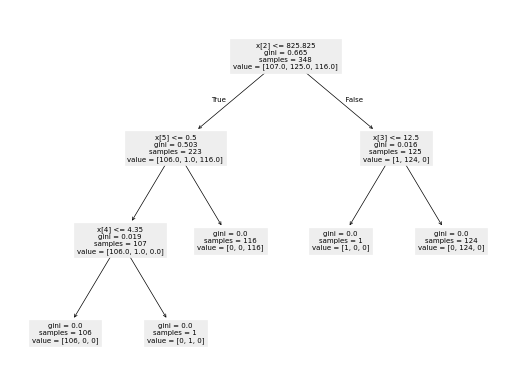

In [58]:
## decision tree time
tree_cf = tree.DecisionTreeClassifier()
tree_cf.fit(ecomm_features, ecomm_targets)

tree.plot_tree(tree_cf)

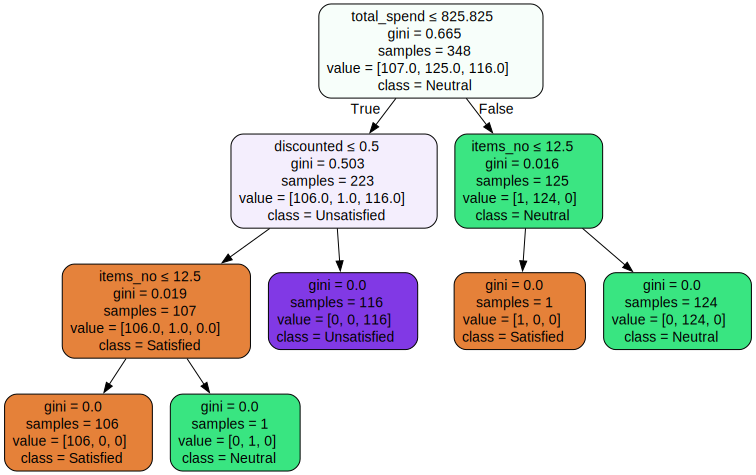

In [10]:
tree_data = tree.export_graphviz(tree_cf, 
                             feature_names=ecomm_features.columns, 
                             class_names=ecomm_targets.unique(),
                             filled=True, 
                             rounded=True,
                             special_characters=True)
graph = graphviz.Source(tree_data)  
graph

## Google merch shop

In [11]:
DATASET = './data/bq-results-20250515-133239-1747315972611.csv'

In [12]:
raw_df = pl.read_csv(DATASET)
raw_df.describe()

statistic,event_date,event_name,event_timestamp,user_pseudo_id,country,device_category,traffic_source,page_location,revenue,engagement_time_msec
str,f64,str,f64,f64,str,str,str,str,str,f64
"""count""",87534.0,"""87534""",87534.0,87534.0,"""87534""","""87534""","""87534""","""87534""","""40""",45072.0
"""null_count""",0.0,"""0""",0.0,0.0,"""0""","""0""","""0""","""0""","""87494""",42462.0
"""mean""",2.0201e7,null,1.6088e15,2.5465e8,null,null,null,null,null,11551.687101
"""std""",0.809831,null,7.3185e10,1.1978e9,null,null,null,null,null,29950.8142
"""min""",2.0201223e7,"""add_payment_info""",1.6087e15,1.0021e6,"""(not set)""","""desktop""","""(data deleted)""","""http://shop.googlemerchandises…","""11""",1.0
"""25%""",2.0201223e7,null,1.6087e15,6.1339e6,null,null,null,null,null,1443.0
"""50%""",2.0201224e7,null,1.6088e15,2.3000e7,null,null,null,null,null,5266.0
"""75%""",2.0201224e7,null,1.6089e15,6.1039e7,null,null,null,null,null,12752.0
"""max""",2.0201225e7,"""view_search_results""",1.6089e15,9.8968e9,"""Vietnam""","""tablet""","""<Other>""","""https://www.googlemerchandises…","""99""",2.971499e6


In [13]:
data = raw_df.with_columns(
    pl.col("event_date").cast(pl.String).str.to_date(format="%Y%m%d"),
    pl.col("event_name").cast(pl.Categorical),
    pl.col("event_timestamp").cast(pl.Datetime),
    pl.col("user_pseudo_id").cast(pl.String),
    pl.col("country").cast(pl.Categorical),
    pl.col("device_category").cast(pl.Categorical),
    pl.col("revenue").cast(pl.UInt16).fill_null(0),
    pl.col("engagement_time_msec").cast(pl.UInt64).fill_null(0)
)
data.head()

event_date,event_name,event_timestamp,user_pseudo_id,country,device_category,traffic_source,page_location,revenue,engagement_time_msec
date,cat,datetime[μs],str,cat,cat,str,str,u16,u64
2020-12-25,"""page_view""",2020-12-25 18:30:04.450512,"""1002118.4468776061""","""United States""","""desktop""","""(direct)""","""https://shop.googlemerchandise…",0,0
2020-12-25,"""first_visit""",2020-12-25 18:30:04.450512,"""1002118.4468776061""","""United States""","""desktop""","""(direct)""","""https://shop.googlemerchandise…",0,0
2020-12-25,"""session_start""",2020-12-25 18:30:04.450512,"""1002118.4468776061""","""United States""","""desktop""","""(direct)""","""https://shop.googlemerchandise…",0,0
2020-12-25,"""scroll""",2020-12-25 21:51:55.659562,"""1019549.7191616026""","""United States""","""mobile""","""(organic)""","""https://googlemerchandisestore…",0,554
2020-12-25,"""user_engagement""",2020-12-25 21:51:55.659562,"""1019549.7191616026""","""United States""","""mobile""","""(organic)""","""https://googlemerchandisestore…",0,2755


In [14]:
### check unique events
data.group_by("event_name").agg(
    pl.col("event_name").count().alias("counts"),
    pl.col("user_pseudo_id").unique().count().alias("unique_users"),
    pl.col("revenue").mean(),
    pl.col("engagement_time_msec").mean()
).sort("counts", descending=True)
#.transpose(column_names="event_name", include_header=True)

event_name,counts,unique_users,revenue,engagement_time_msec
cat,u32,u32,f64,f64
"""page_view""",24669,7861,0.0,0.0
"""user_engagement""",20242,5998,0.0,13609.640747
"""scroll""",9873,3302,0.0,13897.413046
"""session_start""",8807,7909,0.0,0.0
"""view_item""",7660,1447,0.0,12221.074674
"""first_visit""",6975,6974,0.0,0.0
"""view_promotion""",3757,2421,0.0,929.307958
"""add_to_cart""",2061,356,0.0,3075.684134
"""select_item""",985,431,0.0,4150.831472


### user engagement levels

In [32]:
### plot by half hour
engagement = data.group_by(pl.col("event_timestamp").dt.round("30m")).agg(
    #pl.col("event_timestamp").dt.round("30m").alias("time"),
    pl.col("engagement_time_msec").sum() / 1_000, 
    pl.col("event_name").count().alias("events"),
    pl.col("revenue").sum().alias("total_revenue"),
).sort("event_timestamp")
time, eng, events, revenue = engagement.cast({"event_timestamp" : pl.String}).to_numpy().transpose()

time = time.astype(np.datetime64)

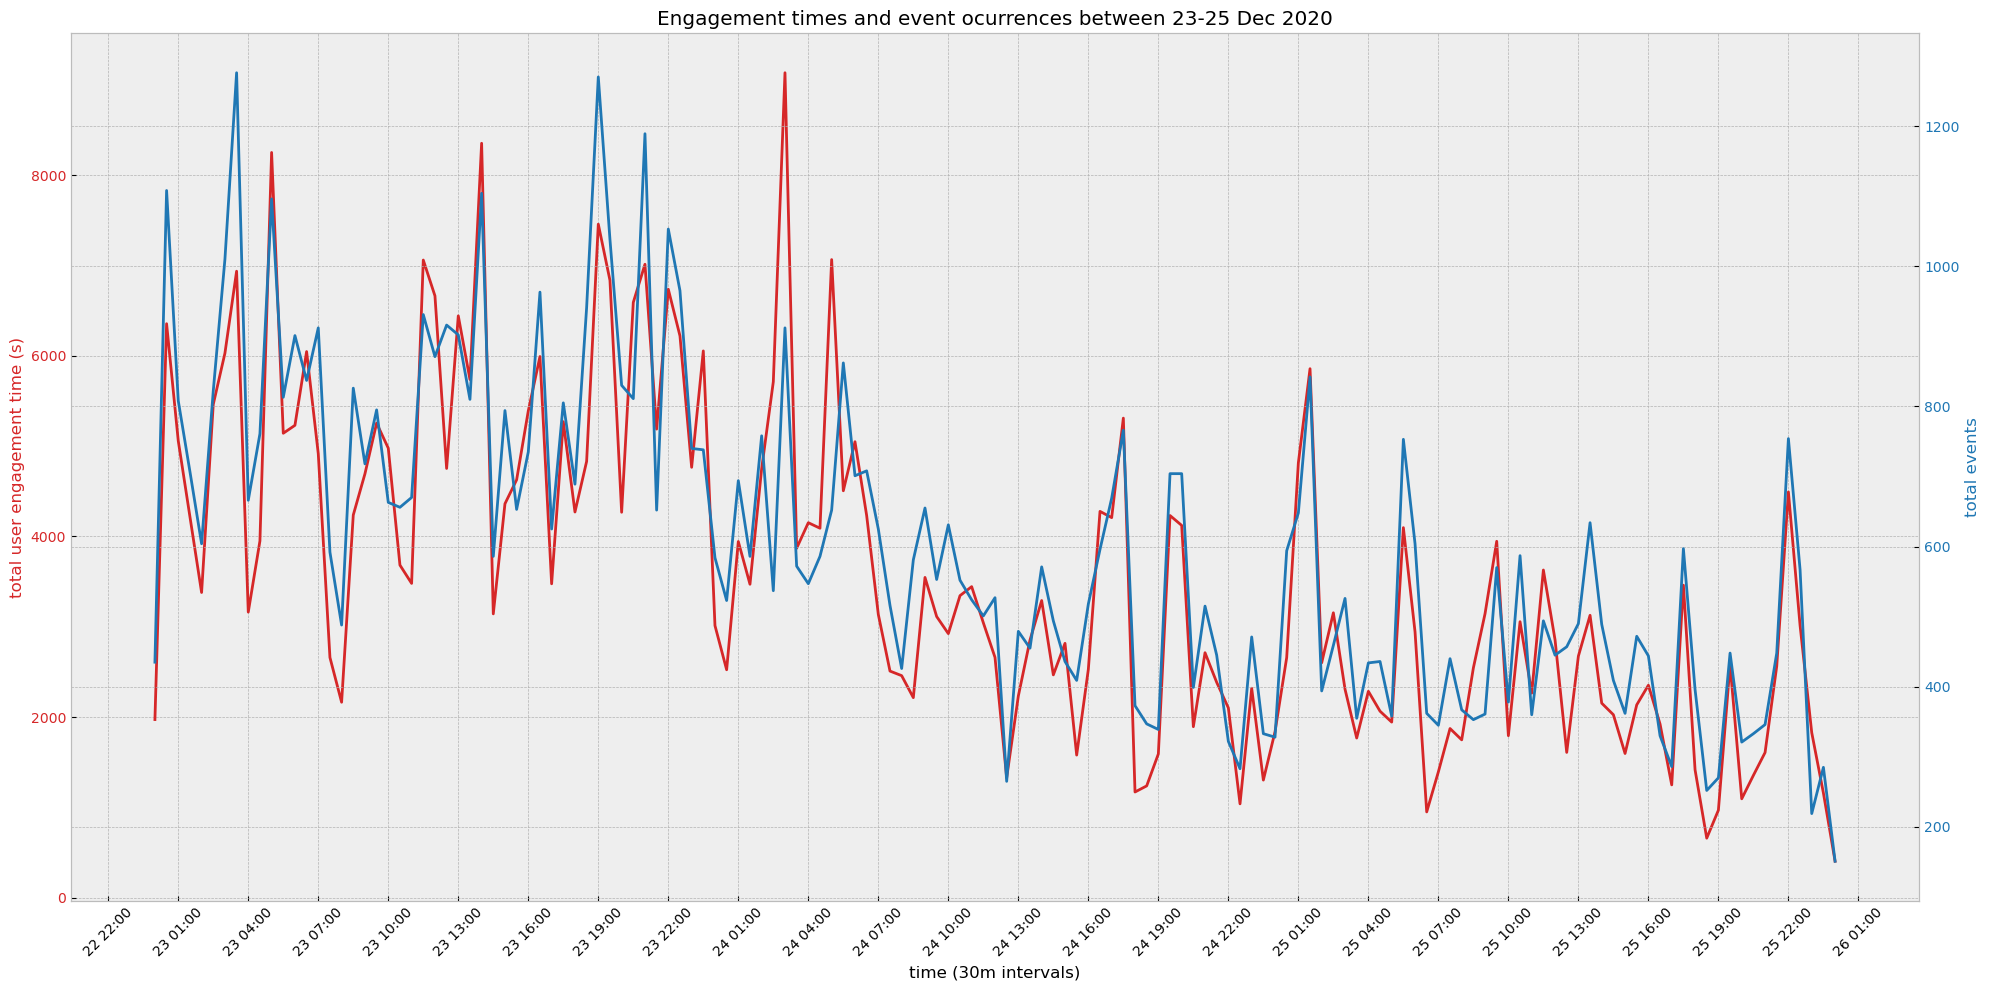

In [33]:
fig, ax1 = plt.subplots(figsize=[20,10])

plt.title("Engagement times and event ocurrences between 23-25 Dec 2020")

color = 'tab:red'
ax1.set_xlabel('time (30m intervals)')

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.xticks(rotation=45)

ax1.set_ylabel('total user engagement time (s)', color=color)
ax1.plot(time, eng, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total events', color=color)  # we already handled the x-label with ax1
ax2.plot(time, events, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

> Based on the graph i decided that hours between 01:00 to 04:00 provide a lot of interesting datapoints

In [39]:
engagement = engagement.filter(pl.col("event_timestamp").dt.hour().is_between(1, 4))
time, eng, events, revenue = engagement.cast({"event_timestamp" : pl.String}).to_numpy().transpose()

time = time.astype(np.datetime64)

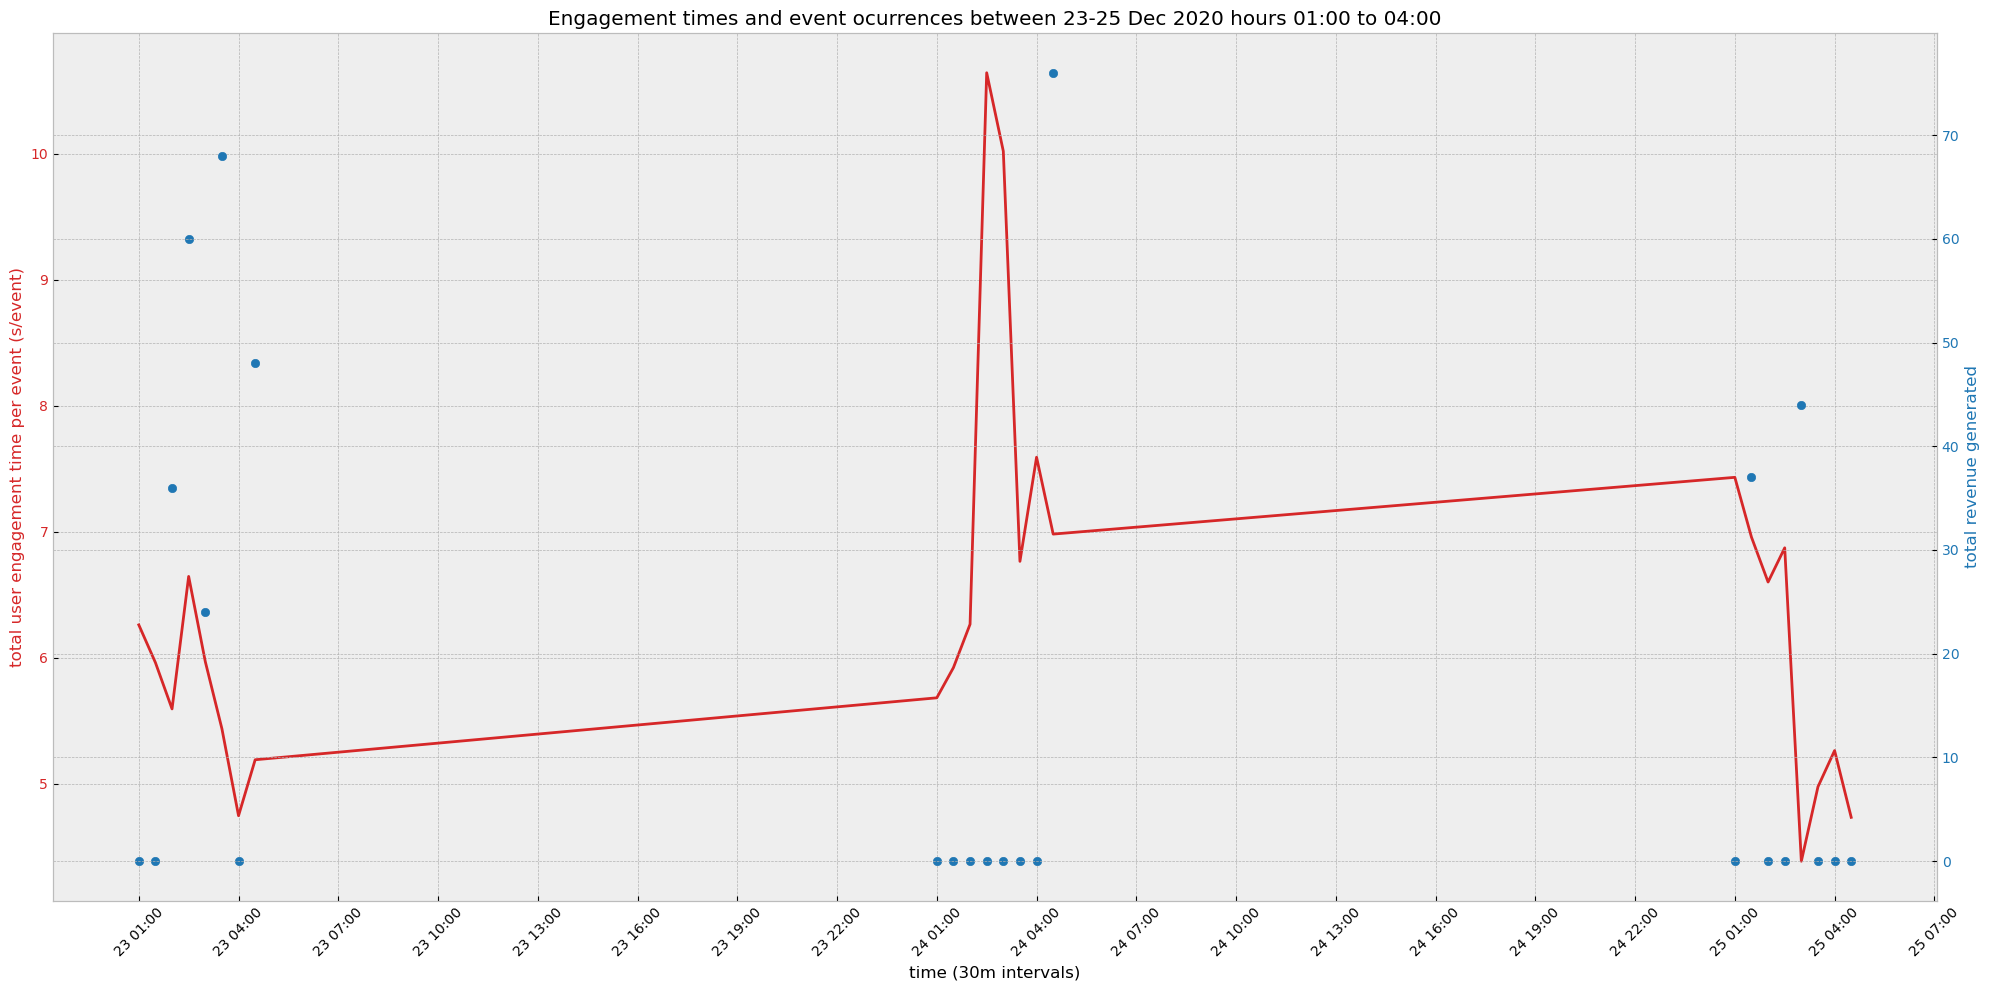

In [40]:
fig, ax1 = plt.subplots(figsize=[20,10])

plt.title("Engagement times and event ocurrences between 23-25 Dec 2020 hours 01:00 to 04:00")

color = 'tab:red'
ax1.set_xlabel('time (30m intervals)')

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.xticks(rotation=45)

ax1.set_ylabel('total user engagement time per event (s/event)', color=color)
ax1.plot(time, eng / events, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total revenue generated', color=color)  # we already handled the x-label with ax1
ax2.scatter(time, revenue, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

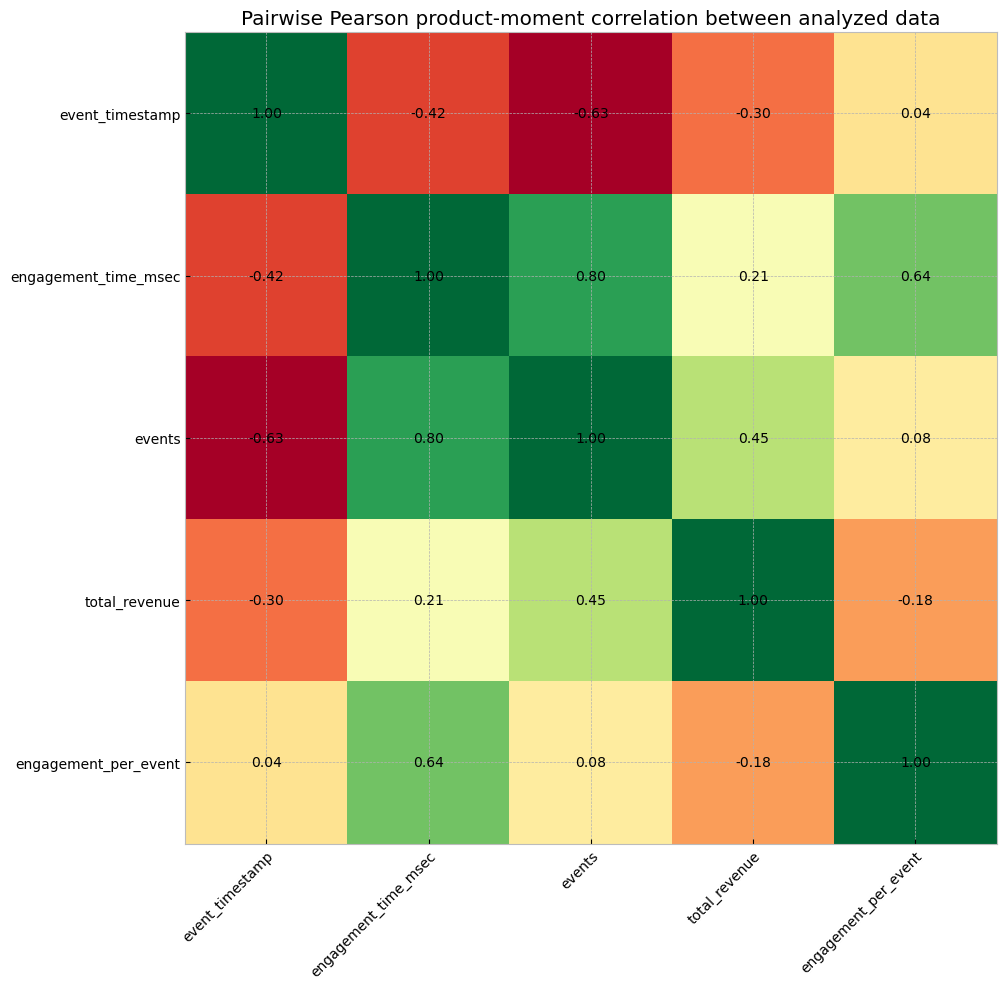

In [57]:
### check if there exists a corelation between time per event and revenue
fig, ax = plt.subplots(figsize=[20,10])

correlations = engagement.with_columns((pl.col("engagement_time_msec") / pl.col("events")).alias("engagement_per_event"))

corr_data = correlations.corr().to_numpy()

ax.imshow(corr_data, cmap="RdYlGn")
# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(correlations.columns)), labels=correlations.columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(correlations.columns)), labels=correlations.columns)

# Loop over data dimensions and create text annotations.
for i in range(len(correlations.columns)):
    for j in range(len(correlations.columns)):
        text = ax.text(j, i, f"{corr_data[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax.set_title("Pairwise Pearson product-moment correlation between analyzed data")
fig.tight_layout()

plt.show()

> as can be see engagement time strongly correlates with total events which was expected
> In this period it also negatively correlates with time which can be attributed to the holiday period
> there seems to be no distinguishable correlation to total generated revenue

### Customer behavior model graph